# **UEFA Champions League predicciones**

### En este archivo trataremos con diferentes modelos de predicción para predecir el ganador del torneo de fútbol de esta temporada 23-24.

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento, aunque primero hay que asegurarnos que las tenemos instaladas.

In [17]:
# Importamos librerías

# Visualización de datos
%matplotlib inline

# Manipulación de datos
import pandas as pd
from pandas.plotting import scatter_matrix

# Preparación de los datos
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

# Modelos de predicción
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report

El siguiente paso es importar los datos con lo que vamos a trabajar.

In [18]:
overall = pd.read_csv('../data/overall_limpio.csv')
overall.head()

,Season,Rk,Squad,Country,MP,W,D,L,GF,GA,GD,Pts,Attendance,Top Team Scorer,Goalkeeper,Top Team Scorer Goals
0,2022-2023,W,Manchester City,Inglaterra,13.0,8.0,5.0,0.0,32.0,5.0,27.0,29.0,63639.0,Erling Haaland,Ederson,12.0
1,2022-2023,F,Inter,Italia,13.0,7.0,3.0,3.0,19.0,11.0,8.0,24.0,71415.0,Edin Džeko,André Onana,4.0
2,2022-2023,SF,Real Madrid,España,12.0,8.0,2.0,2.0,26.0,13.0,13.0,26.0,58761.0,Vinicius Júnior,Thibaut Courtois,7.0
3,2022-2023,SF,Milan,Italia,12.0,5.0,3.0,4.0,15.0,11.0,4.0,18.0,72546.0,Olivier Giroud,Mike Maignan,5.0
4,2022-2023,QF,Bayern Munich,Alemania,10.0,8.0,1.0,1.0,22.0,6.0,16.0,25.0,75000.0,"Leroy Sané,Eric Maxim Choupo-Moting",Yann Sommer,4.0


### Exploración de datos

Hacemos unos pequeños ajustes a los datos antes de hacer las predicciones. Como por ejemplo, eliminar aquellas filas vacías.

In [19]:
# Eliminamos las filas que contienen valores nulos
overall = overall.dropna()

Visualizamos los datos para poder analizar como de relacionadas están las columnas numéricas entre ellas.

array([[<AxesSubplot:xlabel='MP', ylabel='MP'>,
        <AxesSubplot:xlabel='W', ylabel='MP'>,
        <AxesSubplot:xlabel='D', ylabel='MP'>,
        <AxesSubplot:xlabel='L', ylabel='MP'>,
        <AxesSubplot:xlabel='GF', ylabel='MP'>,
        <AxesSubplot:xlabel='GA', ylabel='MP'>,
        <AxesSubplot:xlabel='GD', ylabel='MP'>,
        <AxesSubplot:xlabel='Pts', ylabel='MP'>,
        <AxesSubplot:xlabel='Attendance', ylabel='MP'>,
        <AxesSubplot:xlabel='Top Team Scorer Goals', ylabel='MP'>],
       [<AxesSubplot:xlabel='MP', ylabel='W'>,
        <AxesSubplot:xlabel='W', ylabel='W'>,
        <AxesSubplot:xlabel='D', ylabel='W'>,
        <AxesSubplot:xlabel='L', ylabel='W'>,
        <AxesSubplot:xlabel='GF', ylabel='W'>,
        <AxesSubplot:xlabel='GA', ylabel='W'>,
        <AxesSubplot:xlabel='GD', ylabel='W'>,
        <AxesSubplot:xlabel='Pts', ylabel='W'>,
        <AxesSubplot:xlabel='Attendance', ylabel='W'>,
        <AxesSubplot:xlabel='Top Team Scorer Goals', ylabel='W'>]

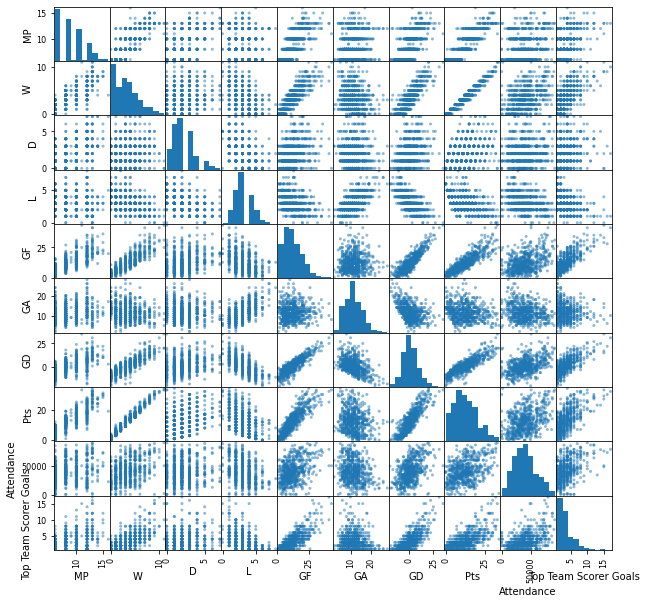

In [20]:
scatter_matrix(overall[['MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Attendance', 'Top Team Scorer Goals']], figsize=(10,10))

### Preparación de los datos.

Ahora ya definimos nuestras variables para las predicciones. En nuestro caso, queremos predecir los resultados del torneo, por que querremos predecir la columna 'Rk' que muestra los rankings.

In [21]:
X = overall.drop(labels=['Rk'], axis=1)
y = overall['Rk']

# Estandarizamos los datos

# Columnas a estandarizar
cols = [['MP', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Attendance', 'Top Team Scorer Goals']]

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    X[col] = scale(X[col])

Queremos variables continuas que sean enteras para nuestros datos de entrada, así que eliminemos cualquier variable categórica

In [22]:
def preprocesar_variables(X):
    ''' Preprocesa los datos de fútbol y convierte las variables categóricas en variables dummy '''
    
    # Inicializa un nuevo DataFrame de salida
    output = pd.DataFrame(index = X.index)

    # Investigar cada columna de características para los datos
    for col, col_data in X.iteritems():

        # Si el tipo de dato es categórico, convertimos en dummy
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Recopilar las columnas revisadas
        output = output.join(col_data)
    
    return output


In [23]:
X = preprocesar_variables(X)
print ("Columnas de variables procesadas ({} en total):\n{}".format(len(X.columns), list(X.columns)))

Columnas de variables procesadas (965 en total):
['Season_2003-2004', 'Season_2004-2005', 'Season_2005-2006', 'Season_2006-2007', 'Season_2007-2008', 'Season_2008-2009', 'Season_2009-2010', 'Season_2010-2011', 'Season_2011-2012', 'Season_2012-2013', 'Season_2013-2014', 'Season_2014-2015', 'Season_2015-2016', 'Season_2016-2017', 'Season_2017-2018', 'Season_2018-2019', 'Season_2019-2020', 'Season_2020-2021', 'Season_2021-2022', 'Season_2022-2023', 'Squad_AEK Athens', 'Squad_APOEL FC', 'Squad_AZ Alkmaar', 'Squad_Aalborg', 'Squad_Ajax', 'Squad_Anderlecht', 'Squad_Anorthosis', 'Squad_Arsenal', 'Squad_Artmedia', 'Squad_Atalanta', 'Squad_Athletic Club', 'Squad_Atlético Madrid', 'Squad_Austria Wien', 'Squad_Auxerre', 'Squad_BATE Borisov', 'Squad_Barcelona', 'Squad_Basel', 'Squad_Bayern Munich', 'Squad_Başakşehir', 'Squad_Benfica', 'Squad_Betis', 'Squad_Beşiktaş', 'Squad_Bordeaux', 'Squad_Braga', 'Squad_Bursaspor', 'Squad_CFR Cluj', 'Squad_CSKA Moscow', 'Squad_Celta Vigo', 'Squad_Celtic', 'Squa

Dividimos los datos en entrenamiento y prueba.

In [24]:
# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify = y)

### Modelos de predicción.

Comenzamos con la Regresión Logística.

In [25]:
lr = LogisticRegression(random_state=42, max_iter=1000, C=1.0)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

In [26]:
svc = SVC(random_state = 912, kernel='rbf')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [27]:
xgb = GradientBoostingClassifier(random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [44]:
# Initialize an empty list to store squad names
squad_names_with_1 = []

# Iterate over the columns of the DataFrame
for col in X_test.columns:
    # Check if the column name contains 'Squad_name' and if it contains the value 1
    if 'Squad_name' in col and X_test[col].eq(1).any():
        # Extract the squad name from the column name and append it to the list
        squad_name = col.split('_')[1]  # Assuming squad names are separated by underscores
        squad_names_with_1.append(squad_name)

# Print the list of squad names that contain 1
print(squad_names_with_1)


[]


In [31]:
print(xgb_pred)

['GR' 'R16' 'GR' 'R16' 'R16' 'W' 'R16' 'R16' 'SF' 'R16' 'GR' 'GR' 'GR'
 'R16' 'R16' 'GR' 'GR' 'SF' 'F' 'GR' 'GR' 'GR' 'F' 'F' 'F' 'GR' 'R16' 'GR'
 'GR' 'QF' 'R16' 'R16' 'GR' 'GR' 'GR' 'R16' 'R16' 'R16' 'GR' 'GR' 'GR'
 'R16' 'GR' 'QF' 'GR' 'GR' 'GR' 'QF' 'SF' 'GR' 'GR' 'W' 'GR' 'R16' 'R16'
 'R16' 'GR' 'QF' 'GR' 'R16' 'R16' 'GR' 'GR' 'GR' 'GR' 'R16' 'GR' 'R16'
 'SF' 'GR' 'GR' 'GR' 'GR' 'R16' 'GR' 'R16' 'R16' 'GR' 'GR' 'GR' 'W' 'R16'
 'GR' 'GR' 'R16' 'GR' 'R16' 'R16' 'QF' 'GR' 'QF' 'QF' 'GR' 'GR' 'GR' 'SF'
 'R16' 'QF' 'R16' 'W' 'GR' 'GR' 'GR' 'GR' 'GR' 'R16' 'R16' 'GR' 'QF' 'R16'
 'F' 'R16' 'R16' 'GR' 'GR' 'GR' 'GR' 'GR' 'GR' 'R16' 'GR' 'R16' 'GR' 'GR'
 'GR' 'QF' 'R16' 'GR' 'GR' 'QF' 'R16' 'GR' 'GR' 'R16' 'F' 'R16' 'GR' 'GR'
 'GR' 'R16' 'GR' 'R16' 'R16' 'QF' 'SF' 'GR' 'GR' 'GR' 'GR' 'GR' 'GR' 'GR'
 'GR' 'R16' 'GR' 'GR' 'SF' 'R16' 'GR' 'R16' 'QF' 'F' 'SF' 'GR' 'R16' 'R16'
 'F' 'QF' 'GR' 'GR' 'SF' 'F' 'GR' 'GR' 'GR' 'F' 'W' 'GR' 'GR' 'W' 'GR'
 'R16' 'GR' 'QF' 'QF' 'GR' 'GR']


### Métricas de evaluación.

Para hacer estas métricas, haremos uso del informe de clasificación (Classification Report), una tabla que resume las métricas de evaluación del rendimiento de un modelo de clasificación en un conjunto de datos de prueba. 

¿Qué métricas aparecen en este informe?

- Precision (Precisión): La precisión indica la proporción de instancias clasificadas como positivas que son verdaderamente positivas. Se calcula como el número de verdaderos positivos dividido por el número total de predicciones positivas (verdaderos positivos más falsos positivos).

- Recall (Recuperación o Sensibilidad): El recall indica la proporción de instancias positivas que fueron correctamente clasificadas. Se calcula como el número de verdaderos positivos dividido por el número total de instancias positivas (verdaderos positivos más falsos negativos).

- F1-score (Puntaje F1): Es la media armónica de la precisión y el recall. Proporciona un equilibrio entre precisión y recall. Se calcula como 2 * (precision * recall) / (precision + recall).

- Support (Soporte): Es el número de muestras verdaderas que pertenecen a cada clase en el conjunto de datos de prueba.

- Accuracy (Exactitud): Es la proporción de muestras correctamente clasificadas entre todas las muestras. Se calcula como el número de muestras correctamente clasificadas dividido por el número total de muestras.

- Macro average (Promedio Macro): Es el promedio sin ponderar de las métricas para cada clase. Calcula las métricas independientemente para cada clase y luego toma el promedio sin tener en cuenta el desequilibrio en el tamaño de las clases.

- Weighted average (Promedio Ponderado): Es el promedio ponderado de las métricas para cada clase, donde cada clase contribuye con su peso relativo al número total de muestras en el conjunto de datos de prueba.

In [28]:
print("\nMétricas Regresión Logística:")
print("Precisión:", accuracy_score(y_test, lr_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, lr_pred))


Métricas Regresión Logística:
Precisión: 0.7112299465240641
Informe de Clasificación:
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         6
          GR       0.87      0.94      0.90        94
          QF       0.53      0.39      0.45        23
         R16       0.70      0.70      0.70        46
          SF       0.17      0.17      0.17        12
           W       0.29      0.33      0.31         6

    accuracy                           0.71       187
   macro avg       0.42      0.42      0.42       187
weighted avg       0.69      0.71      0.70       187



In [29]:
print("\nMétricas SVC:")
print("Precisión:", accuracy_score(y_test, svc_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, svc_pred, zero_division=0))


Métricas SVC:
Precisión: 0.7486631016042781
Informe de Clasificación:
              precision    recall  f1-score   support

           F       0.00      0.00      0.00         6
          GR       0.86      0.88      0.87        94
          QF       0.78      0.61      0.68        23
         R16       0.73      0.76      0.74        46
          SF       0.38      0.50      0.43        12
           W       0.33      0.33      0.33         6

    accuracy                           0.75       187
   macro avg       0.51      0.51      0.51       187
weighted avg       0.74      0.75      0.74       187



In [30]:
print("\nMétricas XGBoost:")
print("Precisión:", accuracy_score(y_test, xgb_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, xgb_pred, zero_division=0))


Métricas XGBoost:
Precisión: 0.7914438502673797
Informe de Clasificación:
              precision    recall  f1-score   support

           F       0.50      0.83      0.62         6
          GR       0.87      0.88      0.88        94
          QF       0.81      0.57      0.67        23
         R16       0.76      0.85      0.80        46
          SF       0.67      0.50      0.57        12
           W       0.33      0.33      0.33         6

    accuracy                           0.79       187
   macro avg       0.66      0.66      0.65       187
weighted avg       0.80      0.79      0.79       187

